In [1]:
Output = ('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1013. Microbiome Peanut Allergy/P1013.3. Analyses/P1013.4. Outcome Prediction/Output')
cur_date = "122725"

library(readxl)
library(tidyverse)
library(factoextra)
library(Hmisc)
library(ggsci)
library(ggrepel)
library(umap)
library(ggpca)

# reading in files
saliva_df = data.frame(read_excel("Input/Processed_Saliva_Data_090525.xlsx")) %>%
    mutate(Age = as.numeric(Age), IgE = as.numeric(IgE))
stool_df = data.frame(read_excel("Input/Processed_Stool_Data_090525.xlsx")) %>%
    mutate(Age = as.numeric(Age), IgE = as.numeric(IgE)) 

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:dplyr’:

    src, summarize


The following objects are masked from ‘package:base’:

    format.pval, units




In [2]:
combined_saliva_df = saliva_df %>%
    # normalizing
    mutate(across(c(10:ncol(saliva_df)), ~ log(.x + 2))) %>%
    mutate(Outcome = ifelse(Outcome == 'DS', 'F', Outcome)) %>%
    filter(IgE_Binarized != 'Fail') %>%
    mutate(Outcome = ifelse(Outcome == "F", "Failure",
                                  ifelse(Outcome == "SU", "Sustained Unresponsiveness", Outcome)))
combined_stool_df = stool_df %>%
    mutate(across(c(11:ncol(stool_df)), ~ log(.x + 2))) %>%
    mutate(Outcome = ifelse(Outcome == 'DS', 'F', Outcome)) %>%
    filter(IgE_Binarized != 'Fail') %>%
    mutate(Outcome = ifelse(Outcome == "F", "Failure",
                                  ifelse(Outcome == "SU", "Sustained Unresponsiveness", Outcome)))

# Comparing Baseline Bacteria Abundances

In [3]:
v1_saliva_df = combined_saliva_df %>%
    # only keep participants' baseline samples and those given active treatment
    filter(Time_Point == 'Pre' & Treatment == 'A') %>%
    # making the row names the sample ids
    column_to_rownames(var = 'Sample_ID') 

v1_stool_df = combined_stool_df %>%
    filter(Time_Point == 'Pre' & Treatment == 'A') %>%
    column_to_rownames(var = 'Sample_ID') 

head(v1_saliva_df)

,Original_Sample_ID,Subject_No,Time_Point,Treatment,Outcome,Age,IgE,IgE_Binarized,k__Bacteria.__.__.__.__.__.__,k__Bacteria.p__Absconditabacteria_.SR1..c__Absconditabacteria_.SR1._.C.1..o__Absconditabacteria_.SR1._.O.1..f__Absconditabacteria_.SR1._.F.1..g__Absconditabacteria_.SR1._.G.1..s__bacterium_HMT_874,⋯,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.__.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Aggregatibacter.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Aggregatibacter.s__aphrophilus,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Haemophilus.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Haemophilus.s__parainfluenzae,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..__,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..s__bacterium_HMT_347,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..s__bacterium_HMT_352,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.3..s__bacterium_HMT_351,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.6..s__bacterium_HMT_870
,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Pre_2,FS02baseline,2,Pre,A,Failure,1.873973,14.20,Low,0.6931472,2.8903718,⋯,0.6931472,0.6931472,3.8712010,5.921578,8.119994,0.6931472,0.6931472,0.6931472,0.6931472,4.736198
Pre_4,FS05baseline,4,Pre,A,Failure,3.991781,9.59,Low,3.2580965,0.6931472,⋯,0.6931472,0.6931472,0.6931472,4.718499,7.112327,3.7376696,1.7917595,6.0038871,3.6109179,5.129899
Pre_6,FS07baseline,6,Pre,A,Sustained Unresponsiveness,1.419178,1.32,Low,2.1972246,0.6931472,⋯,0.6931472,0.6931472,0.6931472,7.748029,7.590852,0.6931472,2.8903718,0.6931472,1.9459101,3.401197
Pre_9,FS10baseline,9,Pre,A,Sustained Unresponsiveness,1.389041,0.42,Low,2.3978953,0.6931472,⋯,0.6931472,0.6931472,0.6931472,7.280697,8.360773,0.6931472,0.6931472,0.6931472,0.6931472,2.197225
Pre_11,FS12baseline,11,Pre,A,Failure,1.567123,4.34,Low,2.3025851,0.6931472,⋯,0.6931472,0.6931472,0.6931472,2.890372,8.445482,0.6931472,0.6931472,3.6635616,2.1972246,3.496508
Pre_14,FS15baseline,14,Pre,A,Failure,3.912329,105.00,High,1.3862944,0.6931472,⋯,2.3025851,0.6931472,0.6931472,3.555348,5.575949,0.6931472,0.6931472,7.2909748,4.0943446,4.060443


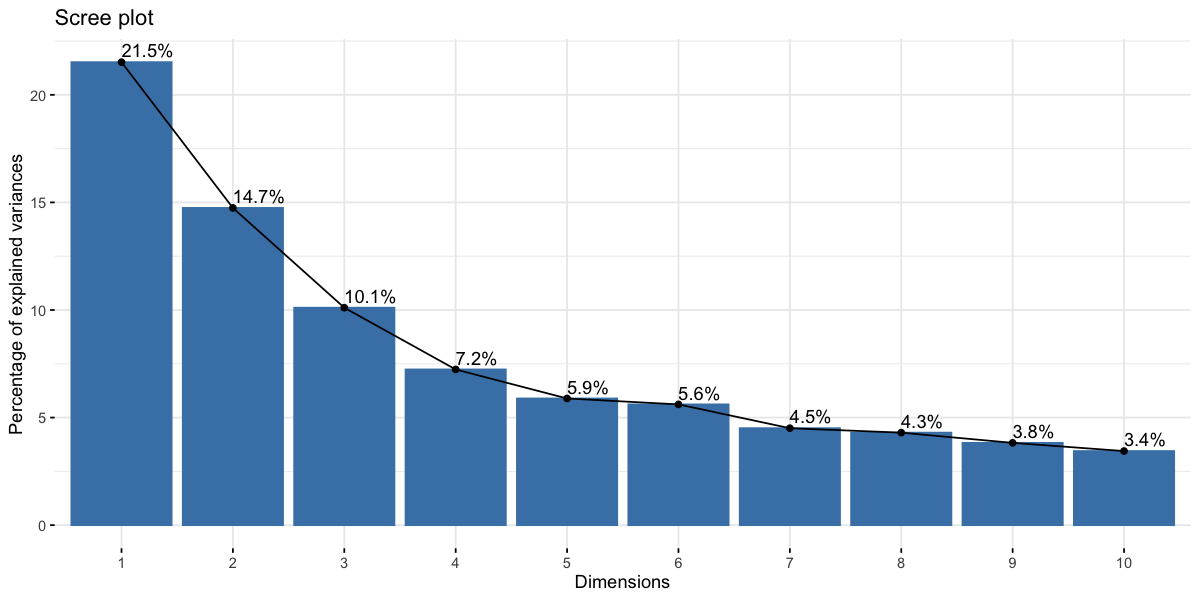

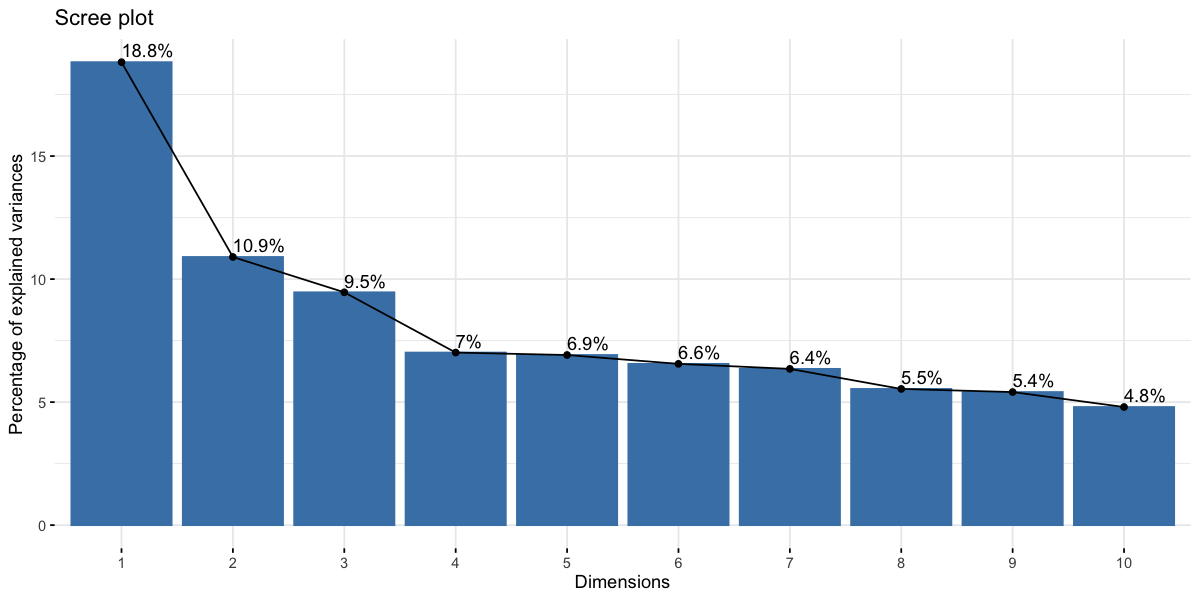

In [4]:
# setting seed for reproducibility
set.seed(12)

pca_saliva_df = v1_saliva_df[,c(6,7,9:ncol(v1_saliva_df))]
pca_stool_df = v1_stool_df[,c(7,8,10:ncol(v1_stool_df))]

# running pca 
saliva_pca = prcomp(pca_saliva_df, center = TRUE, scale = TRUE)
stool_pca = prcomp(pca_stool_df, center = TRUE, scale = TRUE)

# looking at a scree plot to see how much of the variance was captured in the first 2 eigenvectors
options(repr.plot.width = 10, repr.plot.height = 5) #changing size
fviz_eig(saliva_pca, addlabels = TRUE)
fviz_eig(stool_pca, addlabels = TRUE)

In [5]:
# saliva_baseline_pca_df = data.frame(saliva_pca$x[,1:2]) %>%
#                rownames_to_column(var = "SampleID")
# stool_baseline_pca_df = data.frame(stool_pca$x[,1:2]) %>%
#                rownames_to_column(var = "SampleID")

# saliva_bl_pca_df = inner_join(saliva_baseline_pca_df,v1_saliva_df[,1:8] %>% 
#                                      rownames_to_column(var = "SampleID")) %>%
#     # cleaning variable names here
#     mutate(Outcome = ifelse(Outcome == "F", "Failure",
#                                   ifelse(Outcome == "SU", "Sustained Unresponsiveness", Outcome)))
# stool_bl_pca_df = inner_join(stool_baseline_pca_df,v1_stool_df[,1:8] %>% 
#                                      rownames_to_column(var = "SampleID")) %>%
#     # cleaning variable names here
#     mutate(Outcome = ifelse(Outcome == "F", "Failure",
#                                   ifelse(Outcome == "SU", "Sustained Unresponsiveness", Outcome)))

# head(saliva_bl_pca_df)

In [6]:
# options(repr.plot.width=12, repr.plot.height=7) #changing size
# ggplot() + 
#   geom_point(data = saliva_bl_pca_df, aes(x = PC1, y = PC2, color = Outcome, shape = Outcome),
#              size = 3.5) + 
#   stat_ellipse(data = saliva_bl_pca_df , aes(x = PC1, y = PC2, color = Outcome), type = 'norm') + 
#   geom_text_repel(data = saliva_bl_pca_df, 
#                   aes(x = PC1, y = PC2, color = Outcome, label = SampleID), 
#                   segment.size = 0, size = 5, show.legend = FALSE, nudge_y = 0.3) + 

#   theme_light() + 
#   theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
#         axis.line = element_line(colour="black"), #making x and y axes black
#         axis.text = element_text(size = 13), #changing size of x axis labels
#         legend.title = element_text(face = 'bold', size = 15), #changes legend title
#         legend.text = element_text(size = 12), #changes legend text
#         legend.position = "bottom", 
#         legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
#         axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
#         strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
#         strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

#   labs(x = 'Dimension 1 (30%)', y = 'Dimension 2 (24.9%)', #changing axis labels 
#        color = "Outcome", shape = "Outcome") + #changing legend title

#   scale_color_lancet() 

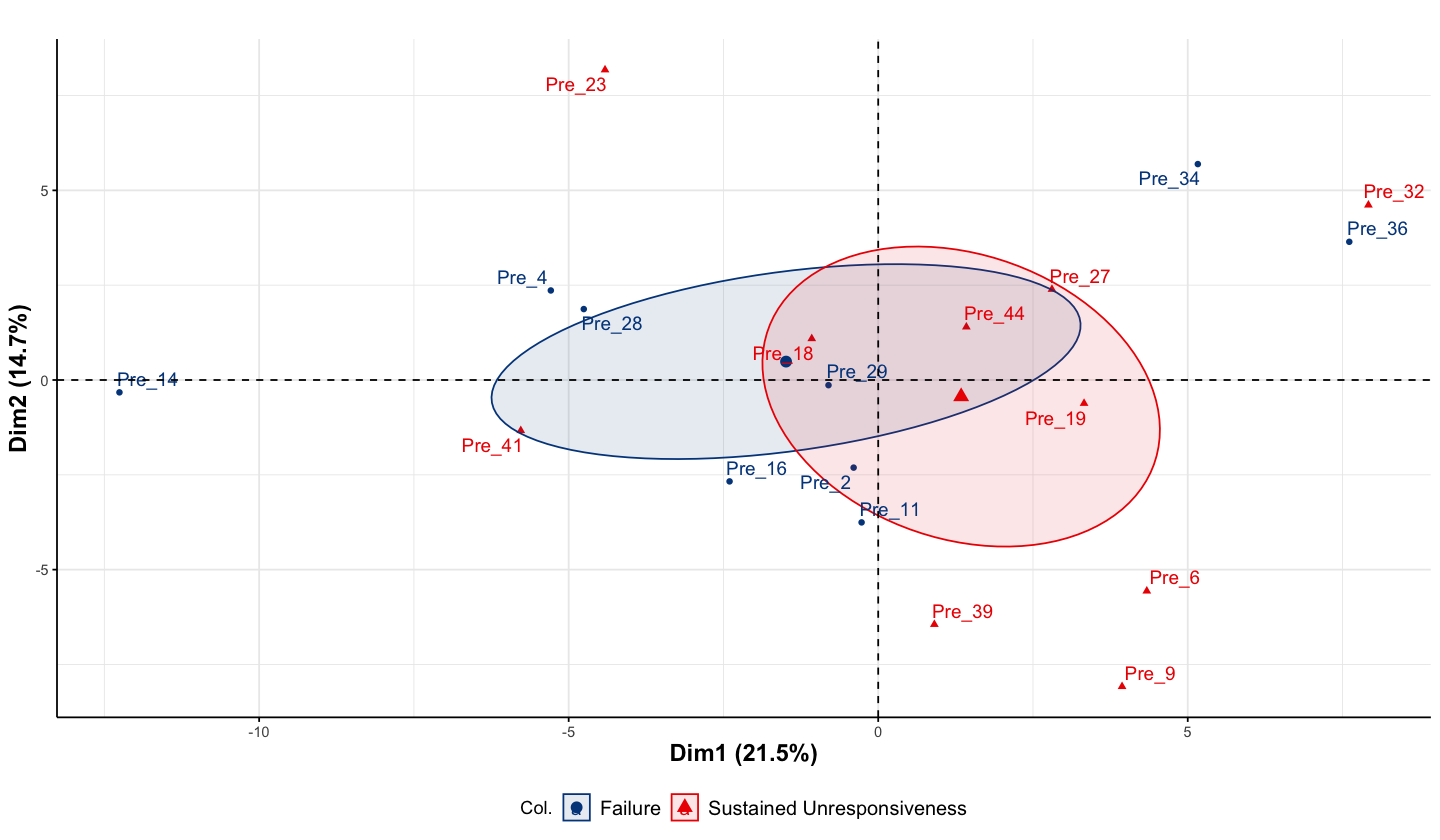

In [7]:
options(repr.plot.width=12, repr.plot.height=7) #changing size
fviz_pca_ind(saliva_pca, 
             col.ind = v1_saliva_df$Outcome, # color by Group
             palette = 'lancet',
             # adding 95% confidence ellipses for each group
             addEllipses = TRUE, # Concentration ellipses
             ellipse.type = "confidence",
             repel = TRUE, title = "") +
    theme(axis.line = element_line(colour = "black"), #making x and y axes black
      legend.text = element_text(size = 12),
      legend.position = 'bottom',
      axis.title = element_text(face = "bold", size = rel(1.3))) #changes axis titles

In [8]:
# ggplot() + 
#   geom_point(data = stool_bl_pca_df, aes(x = PC1, y = PC2, color = Outcome, shape = Outcome),
#              size = 3.5) + 
#   stat_ellipse(data = stool_bl_pca_df , aes(x = PC1, y = PC2, color = Outcome), type = 'norm') + 
#   geom_text_repel(data = stool_bl_pca_df, 
#                   aes(x = PC1, y = PC2, color = Outcome, label = SampleID), 
#                   segment.size = 0, size = 5, show.legend = FALSE, nudge_y = 0.3) + 

#   theme_light() + 
#   theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
#         axis.line = element_line(colour="black"), #making x and y axes black
#         axis.text = element_text(size = 13), #changing size of x axis labels
#         legend.title = element_text(face = 'bold', size = 15), #changes legend title
#         legend.text = element_text(size = 12), #changes legend text
#         legend.position = "bottom", 
#         legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
#         axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
#         strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
#         strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

#   labs(x = 'Dimension 1 (28%)', y = 'Dimension 2 (20%)', #changing axis labels 
#        color = "Outcome", shape = "Outcome") + #changing legend title

#   scale_color_lancet() 

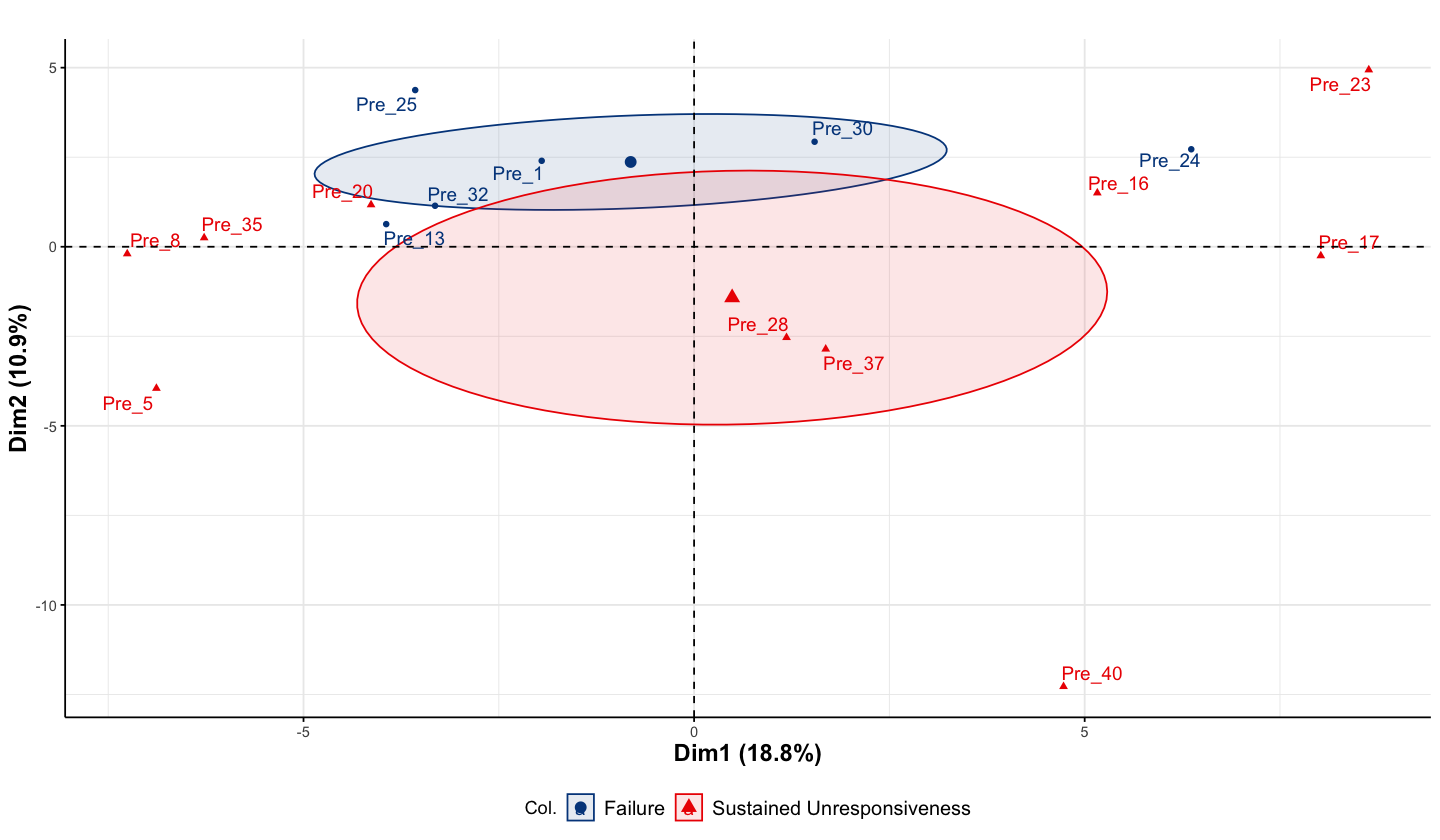

In [9]:
fviz_pca_ind(stool_pca, 
             col.ind = v1_stool_df$Outcome, # color by Group
             palette = 'lancet',
             # #adding 95% confidence ellipses for each group
             addEllipses = TRUE, # Concentration ellipses
             ellipse.type = "confidence",
             repel = TRUE, title = "") +
 theme(axis.line = element_line(colour = "black"), #making x and y axes black
      legend.text = element_text(size = 12),
      legend.position = 'bottom',
      axis.title = element_text(face = "bold", size = rel(1.3))) #changes axis titles

In [10]:
outlier_detection = function(pca_df){
    # """
    # Creating a scoring function for to detect PCA subject outliers. 
    # :param (input): PCA df (df)
    # :output: outlier names
    # """
    
    # getting scores
    scores = pca_df$x[,1:2]
    # identifying samples that are > 6 standard deviations away from the mean
    outlier_indices = apply(scores, 2, function(x) which( abs(x - mean(x)) > (6 * sd(x)) )) %>%
        Reduce(union, .)
    # getting sample names
    outliers = rownames(scores)[outlier_indices]
    
    return(outliers)
}

# calling fn
subject_outliers_saliva = outlier_detection(saliva_pca)
subject_outliers_stool = outlier_detection(stool_pca)            
subject_outliers_saliva
subject_outliers_stool

character(0)

character(0)

## Comparing IgE levels before treatment

In [12]:
v2_saliva_df = combined_saliva_df %>%
    # only keep participants' baseline samples 
    filter(Time_Point == 'Pre') %>% 
    # making the row names the sample ids
    column_to_rownames(var = 'Sample_ID')

v2_stool_df = combined_stool_df %>%
     filter(Time_Point == 'Pre') %>%
    column_to_rownames(var = 'Sample_ID')

head(v2_saliva_df)

,Original_Sample_ID,Subject_No,Time_Point,Treatment,Outcome,Age,IgE,IgE_Binarized,k__Bacteria.__.__.__.__.__.__,k__Bacteria.p__Absconditabacteria_.SR1..c__Absconditabacteria_.SR1._.C.1..o__Absconditabacteria_.SR1._.O.1..f__Absconditabacteria_.SR1._.F.1..g__Absconditabacteria_.SR1._.G.1..s__bacterium_HMT_874,⋯,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.__.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Aggregatibacter.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Aggregatibacter.s__aphrophilus,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Haemophilus.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Haemophilus.s__parainfluenzae,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..__,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..s__bacterium_HMT_347,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..s__bacterium_HMT_352,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.3..s__bacterium_HMT_351,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.6..s__bacterium_HMT_870
,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Pre_1,FS01baseline,1,Pre,P,Failure,3.838356,41.00,High,2.1972246,3.4657359,⋯,4.0775374,2.7080502,0.6931472,5.3706380,6.655440,0.6931472,2.7725887,5.5134287,3.8286414,4.1896547
Pre_2,FS02baseline,2,Pre,A,Failure,1.873973,14.20,Low,0.6931472,2.8903718,⋯,0.6931472,0.6931472,3.8712010,5.9215784,8.119994,0.6931472,0.6931472,0.6931472,0.6931472,4.7361984
Pre_3,FS04baseline,3,Pre,P,Failure,3.715068,67.40,High,1.7917595,0.6931472,⋯,0.6931472,0.6931472,0.6931472,0.6931472,3.806662,6.0306853,3.8918203,0.6931472,1.3862944,6.9584484
Pre_4,FS05baseline,4,Pre,A,Failure,3.991781,9.59,Low,3.2580965,0.6931472,⋯,0.6931472,0.6931472,0.6931472,4.7184989,7.112327,3.7376696,1.7917595,6.0038871,3.6109179,5.1298987
Pre_5,FS06baseline,5,Pre,P,Failure,2.356164,106.00,High,4.4308168,2.5649494,⋯,0.6931472,0.6931472,3.9512437,6.2441669,7.980708,0.6931472,0.6931472,0.6931472,0.6931472,0.6931472
Pre_6,FS07baseline,6,Pre,A,Sustained Unresponsiveness,1.419178,1.32,Low,2.1972246,0.6931472,⋯,0.6931472,0.6931472,0.6931472,7.7480285,7.590852,0.6931472,2.8903718,0.6931472,1.9459101,3.4011974


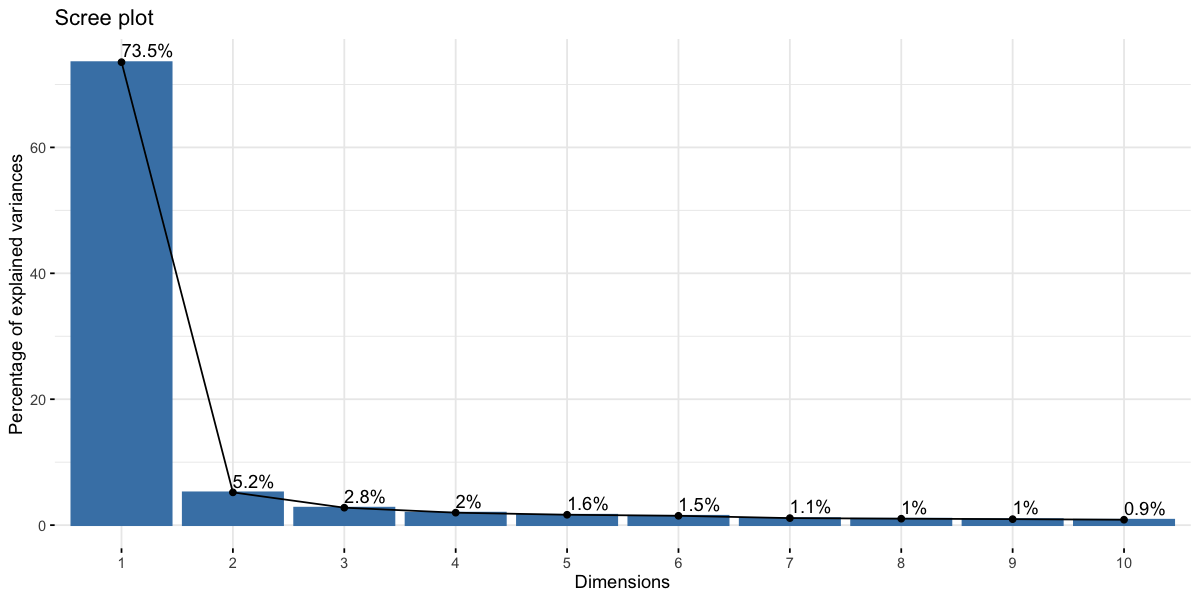

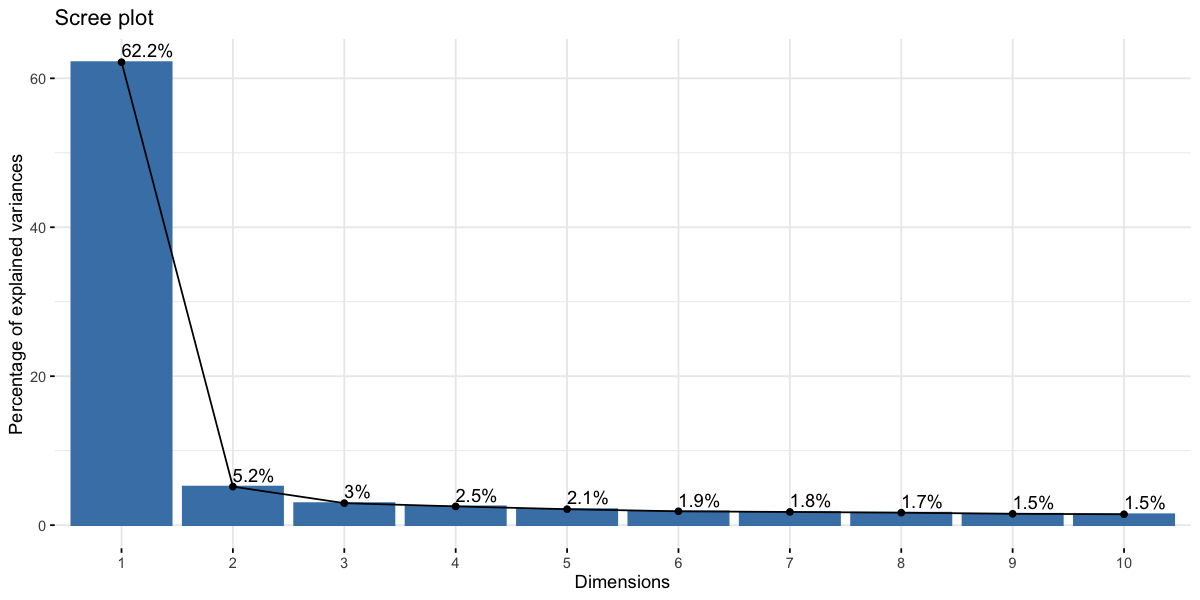

In [13]:
# setting seed for reproducibility
set.seed(12)

pca_saliva_df = v2_saliva_df[,c(6,9:ncol(v2_saliva_df))]
pca_stool_df = v2_stool_df[,c(7,10:ncol(v2_stool_df))]

# running pca 
saliva_pca = prcomp(pca_saliva_df, center = FALSE, scale = TRUE)
stool_pca = prcomp(pca_stool_df, center = FALSE, scale = TRUE)

# looking at a scree plot to see how much of the variance was captured in the first 2 eigenvectors
options(repr.plot.width = 10, repr.plot.height = 5) #changing size
fviz_eig(saliva_pca, addlabels = TRUE)
fviz_eig(stool_pca, addlabels = TRUE)

In [14]:
# calling fn
subject_outliers_saliva = outlier_detection(saliva_pca)
subject_outliers_stool = outlier_detection(stool_pca)  
subject_outliers_saliva
subject_outliers_stool

character(0)

character(0)

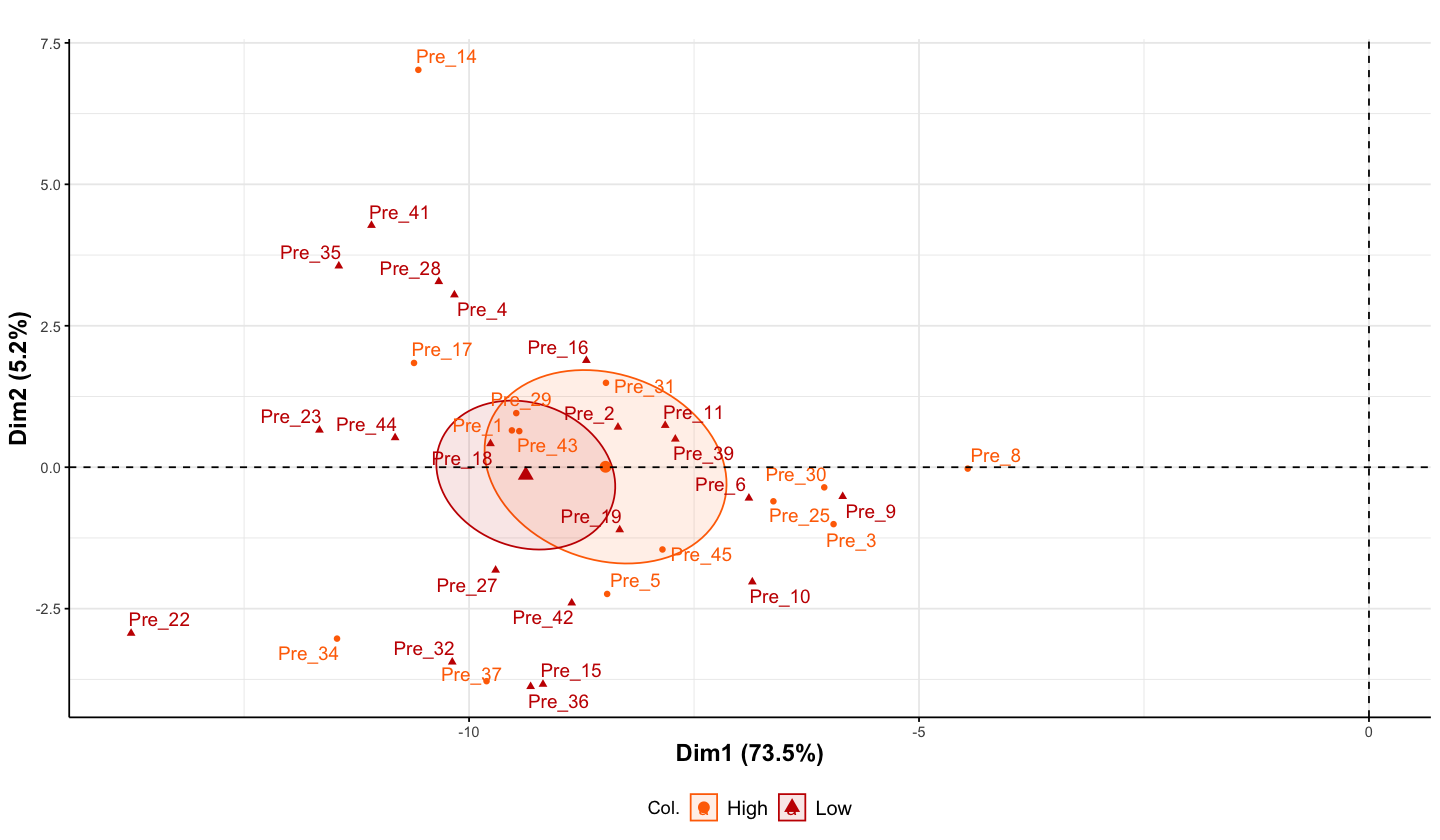

In [15]:
options(repr.plot.width=12, repr.plot.height=7) #changing size
fviz_pca_ind(saliva_pca, 
             col.ind = v2_saliva_df$IgE_Binarized, # color by Group
             palette = 'futurama',
             # adding 95% confidence ellipses for each group
             addEllipses = TRUE, # Concentration ellipses
             ellipse.type = "confidence",
             repel = TRUE, title = "") +
    theme(axis.line = element_line(colour = "black"), #making x and y axes black
      legend.text = element_text(size = 12),
      legend.position = 'bottom',
      axis.title = element_text(face = "bold", size = rel(1.3))) #changes axis titles

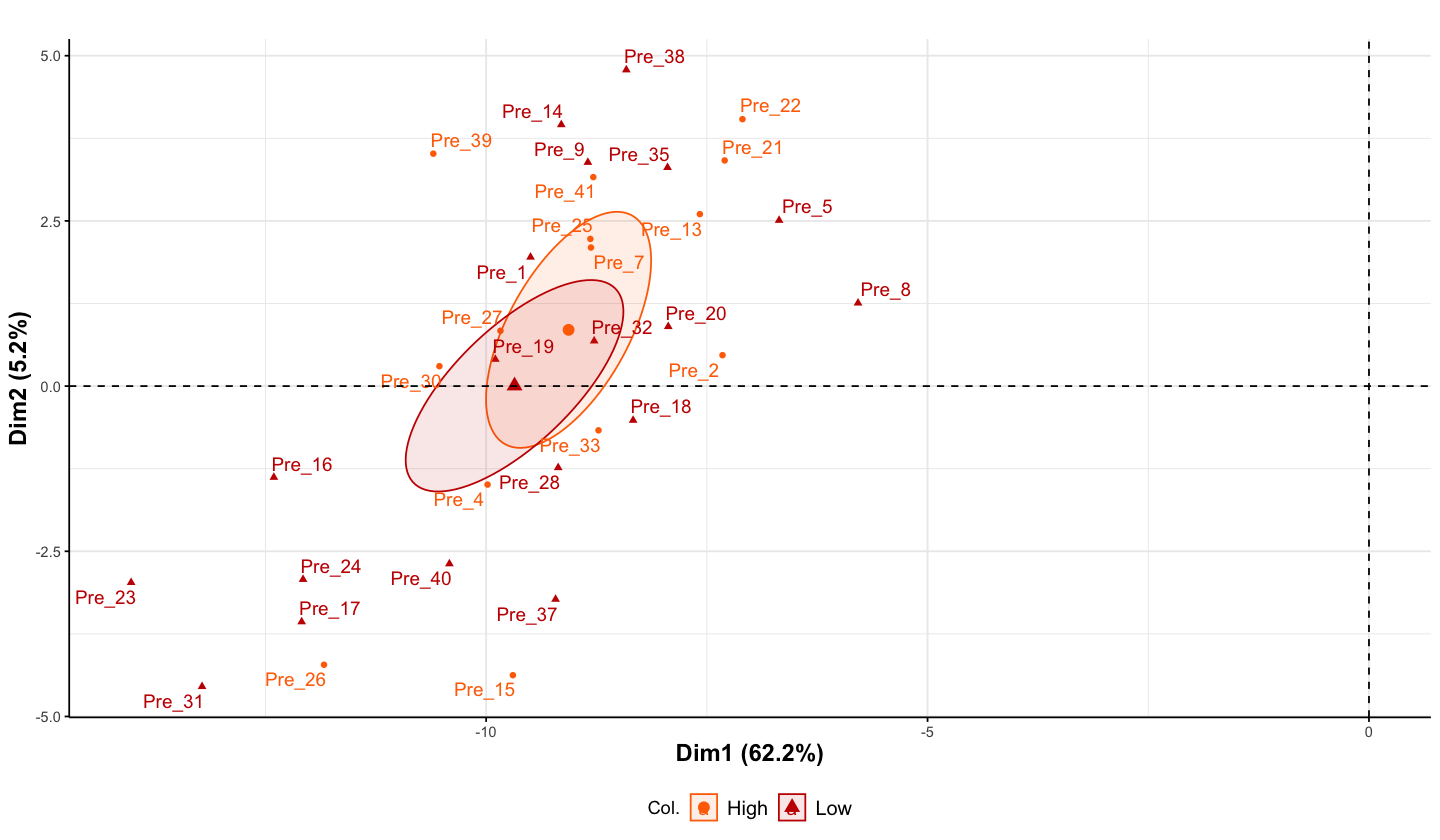

In [16]:
fviz_pca_ind(stool_pca, 
             col.ind = v2_stool_df$IgE_Binarized, # color by Group
             palette = 'futurama',
             # adding 95% confidence ellipses for each group
             addEllipses = TRUE, # Concentration ellipses
             ellipse.type = "confidence",
             repel = TRUE, title = "") +
    theme(axis.line = element_line(colour = "black"), #making x and y axes black
      legend.text = element_text(size = 12),
      legend.position = 'bottom',
      axis.title = element_text(face = "bold", size = rel(1.3))) #changes axis titles

# PCA based on Time Point recieving Active Treatment

Note: To maximize the sample size, I didn't require participants to have both pre and post samples.

In [30]:
`%notin%` <- Negate(`%in%`)

paired_saliva_df = saliva_df  %>%
    # removing those failed the IgE protein
    filter(IgE_Binarized != 'Fail')  %>%
    # ended up reassinging 'DS' to 'F' due to small sample size
    mutate(Outcome = ifelse(Outcome == 'DS', 'F', Outcome)) %>%
    mutate(across(c(10:ncol(saliva_df)), ~ log(.x + 2))) %>%
    # removing 13 participants that don't have pre and post samples
    # keeping subject 20, 24, 26 that have post but not pre data
    filter(#Subject_No %notin% c(1,12,13,16,17,31,32,36,37,43),
    # retaining those given treatment
          Treatment == 'A') %>%
    # cleaning variable names here
    mutate(Outcome = ifelse(Outcome == "F", "Failure",
                                  ifelse(Outcome == "SU", "Sustained Unresponsiveness", Outcome)))

paired_stool_df = stool_df  %>%
    filter(IgE_Binarized != 'Fail') %>%
    mutate(Outcome = ifelse(Outcome == 'DS', 'F', Outcome)) %>%
    mutate(across(c(11:ncol(stool_df)), ~ log(.x + 2))) %>%
     # removing 10 participants that don't have pre and post samples
    # keeping subject 3, 10 that have post but not pre data
    filter(#Subject_No %notin% c(14,15,23,25,27,32,35,39),
          Treatment == 'A') %>%
    # cleaning variable names here
    mutate(Outcome = ifelse(Outcome == "F", "Failure",
                                  ifelse(Outcome == "SU", "Sustained Unresponsiveness", Outcome)))

head(paired_saliva_df)

,Original_Sample_ID,Subject_No,Sample_ID,Time_Point,Treatment,Outcome,Age,IgE,IgE_Binarized,k__Bacteria.__.__.__.__.__.__,⋯,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.__.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Aggregatibacter.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Aggregatibacter.s__aphrophilus,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Haemophilus.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Haemophilus.s__parainfluenzae,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..__,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..s__bacterium_HMT_347,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..s__bacterium_HMT_352,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.3..s__bacterium_HMT_351,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.6..s__bacterium_HMT_870
,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,FS0236mo,2,Post_2,Post,A,Failure,1.873973,14.20,Low,4.1743873,⋯,6.5510803,0.6931472,3.8066625,4.605170,7.413970,0.6931472,0.6931472,6.0520892,4.9972123,4.828314
2,FS02baseline,2,Pre_2,Pre,A,Failure,1.873973,14.20,Low,0.6931472,⋯,0.6931472,0.6931472,3.8712010,5.921578,8.119994,0.6931472,0.6931472,0.6931472,0.6931472,4.736198
3,FS0536mo,4,Post_4,Post,A,Failure,3.991781,9.59,Low,2.0794415,⋯,0.6931472,2.9444390,0.6931472,4.948760,7.833204,0.6931472,0.6931472,6.2225763,3.7135721,4.634729
4,FS05baseline,4,Pre_4,Pre,A,Failure,3.991781,9.59,Low,3.2580965,⋯,0.6931472,0.6931472,0.6931472,4.718499,7.112327,3.7376696,1.7917595,6.0038871,3.6109179,5.129899
5,FS0736mo,6,Post_6,Post,A,Sustained Unresponsiveness,1.419178,1.32,Low,1.3862944,⋯,0.6931472,0.6931472,0.6931472,6.142037,7.407318,2.1972246,0.6931472,5.1298987,4.1431347,6.084499
6,FS07baseline,6,Pre_6,Pre,A,Sustained Unresponsiveness,1.419178,1.32,Low,2.1972246,⋯,0.6931472,0.6931472,0.6931472,7.748029,7.590852,0.6931472,2.8903718,0.6931472,1.9459101,3.401197


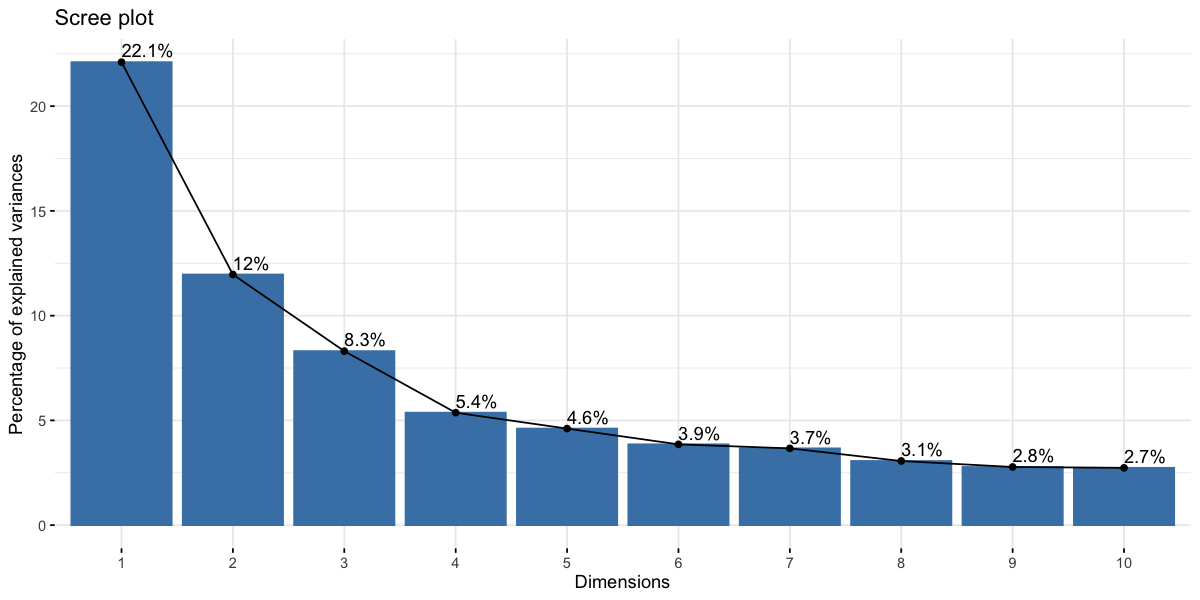

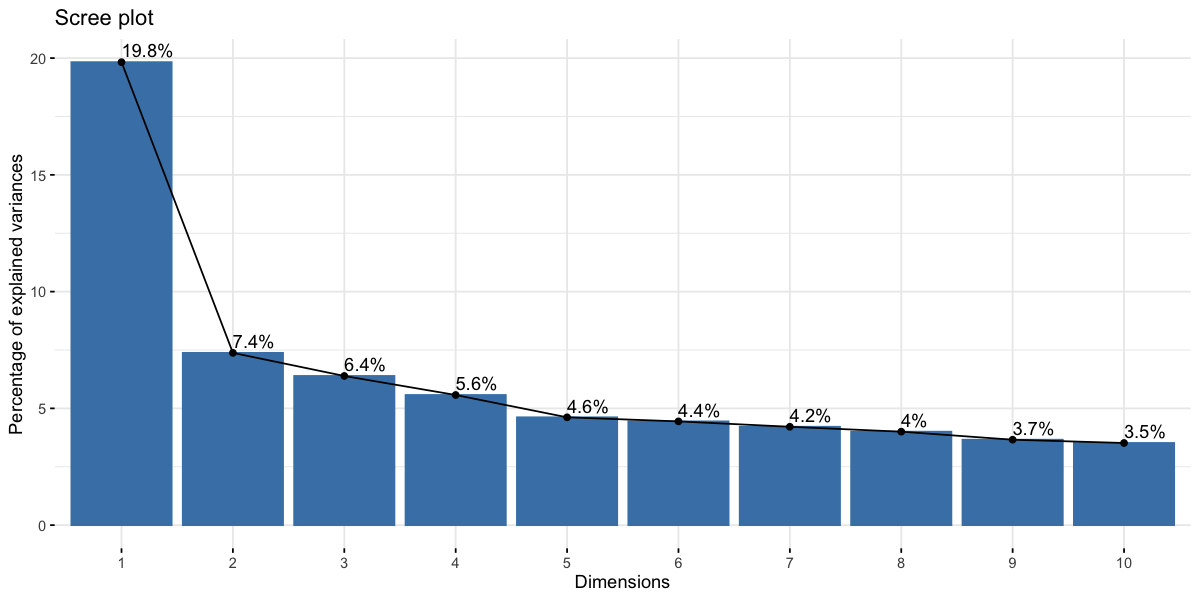

In [31]:
# setting seed for reproducibility
set.seed(12)

pca_saliva_df = paired_saliva_df[,c(7,10:ncol(paired_saliva_df))]
pca_stool_df = paired_stool_df[,c(8,11:ncol(paired_stool_df))]

# running pca 
saliva_pca = prcomp(pca_saliva_df, center = TRUE, scale = TRUE)
stool_pca = prcomp(pca_stool_df, center = TRUE, scale = TRUE)

# looking at a scree plot to see how much of the variance was captured in the first 2 eigenvectors
options(repr.plot.width = 10, repr.plot.height = 5) #changing size
fviz_eig(saliva_pca, addlabels = TRUE)
fviz_eig(stool_pca, addlabels = TRUE)

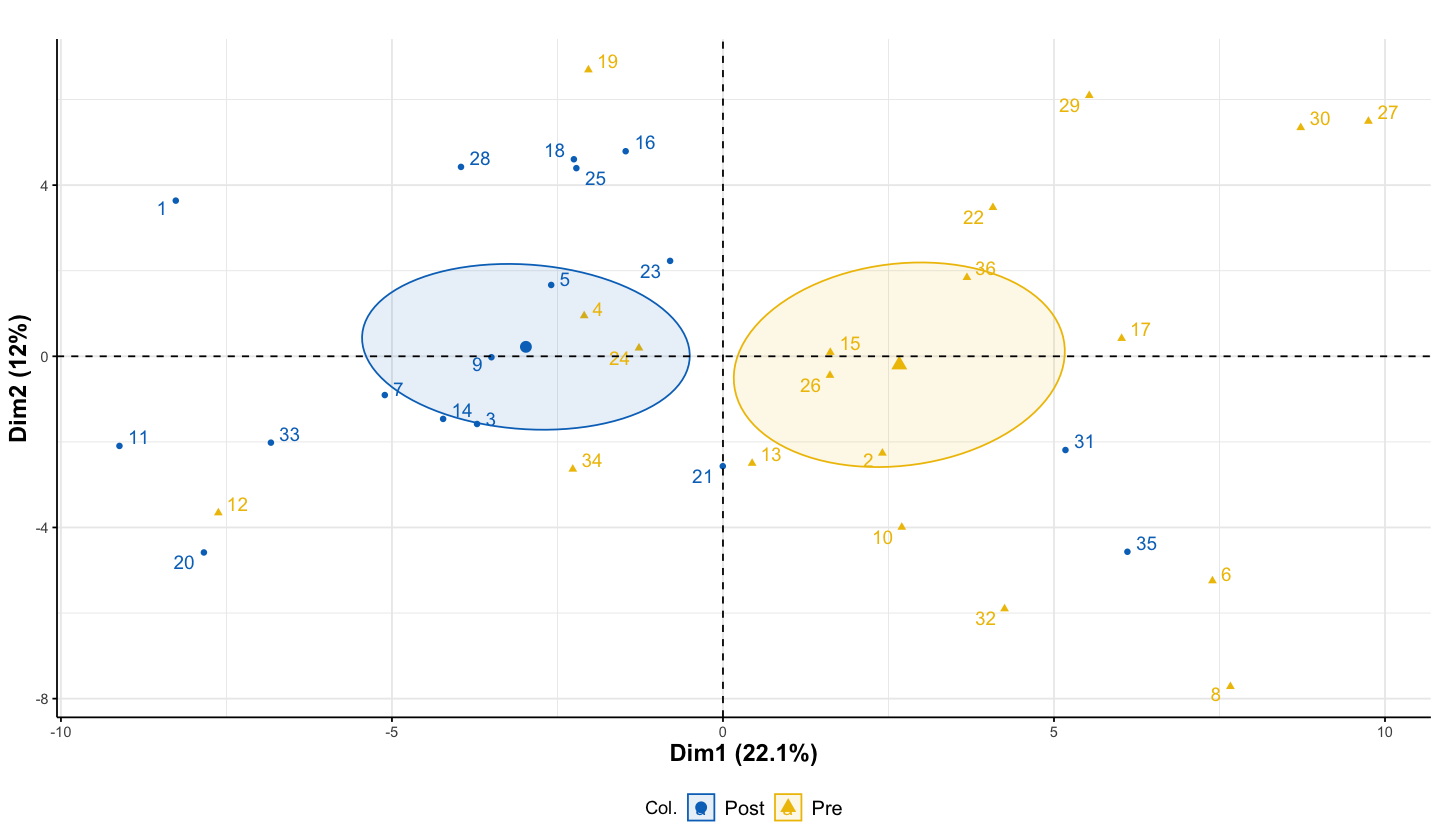

In [32]:
options(repr.plot.width=12, repr.plot.height=7) #changing size
fviz_pca_ind(saliva_pca, 
             col.ind = paired_saliva_df$Time_Point, # color by Group
             palette = 'jco',
             #adding 95% confidence ellipses for each group
             addEllipses = TRUE, # Concentration ellipses
             ellipse.type = "confidence",
             repel = TRUE, title = "") +
    theme(axis.line = element_line(colour = "black"), #making x and y axes black
      legend.text = element_text(size = 12),
      legend.position = 'bottom',
      axis.title = element_text(face = "bold", size = rel(1.3))) #changes axis titles

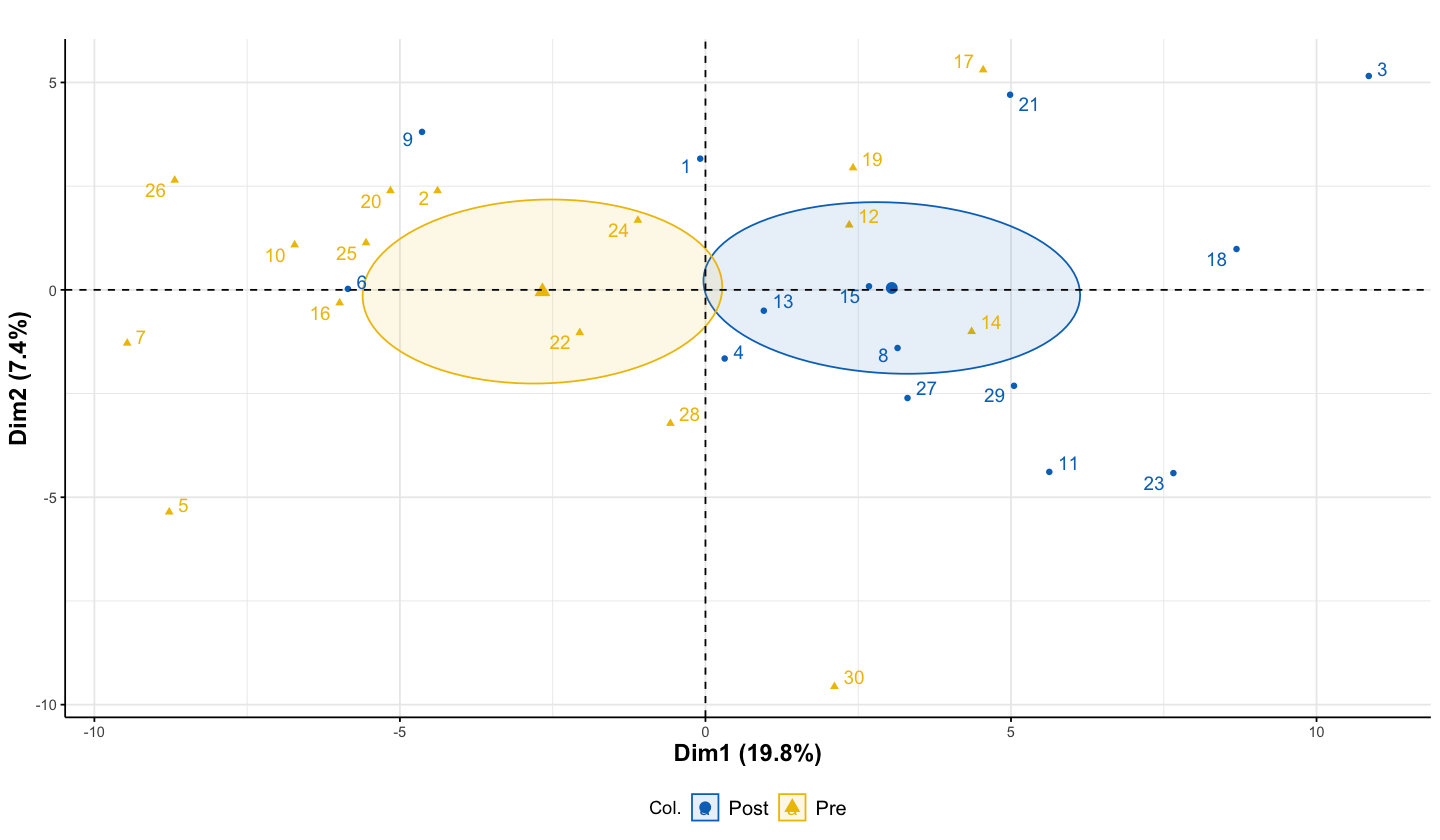

In [33]:
fviz_pca_ind(stool_pca, 
             col.ind = paired_stool_df$Time_Point, # color by Group
             palette = 'jco',
             #adding 95% confidence ellipses for each group
             addEllipses = TRUE, # Concentration ellipses
             ellipse.type = "confidence",
             repel = TRUE, title = "") +
    theme(axis.line = element_line(colour = "black"), #making x and y axes black
      legend.text = element_text(size = 12),
      legend.position = 'bottom',
      axis.title = element_text(face = "bold", size = rel(1.3))) #changes axis titles

In [34]:
# calling fn
subject_outliers_saliva = outlier_detection(saliva_pca)
subject_outliers_stool = outlier_detection(stool_pca)  
subject_outliers_saliva
subject_outliers_stool

NULL

NULL

# UMAP

In [43]:
# setting seed for reproducibility
set.seed(12)

v1_saliva_df = combined_saliva_df %>%
    # only keep participants' baseline samples and those given active treatment
    filter(Time_Point == 'Pre') %>%
    # making the row names the sample ids
    column_to_rownames(var = 'Sample_ID') 

v1_stool_df = combined_stool_df %>%
    filter(Time_Point == 'Pre') %>%
    column_to_rownames(var = 'Sample_ID') 

saliva_umap_outcome = umap(v1_saliva_df[,c(9:ncol(v1_saliva_df))])
stool_umap_outcome = umap(v1_stool_df[,c(10:ncol(v1_stool_df))])

saliva_umap_outcome_df = data.frame(X = saliva_umap_outcome$layout[,1],
                     Y = saliva_umap_outcome$layout[,2],
                     Outcome = v1_saliva_df$Outcome,
                     Age = v1_saliva_df$Age,
                     IgE = v1_saliva_df$IgE_Binarized) %>%
    mutate(IgE = factor(IgE, levels = c('Low', 'High'))) %>%
    rownames_to_column('Sample_ID')

stool_umap_outcome_df = data.frame(X = stool_umap_outcome$layout[,1],
                     Y = stool_umap_outcome$layout[,2],
                     Outcome = v1_stool_df$Outcome,
                     Age = v1_stool_df$Age,
                     IgE = v1_stool_df$IgE_Binarized) %>%
    mutate(IgE = factor(IgE, levels = c('Low', 'High'))) %>%
    rownames_to_column('Sample_ID')

head(saliva_umap_outcome_df)

,Sample_ID,X,Y,Outcome,Age,IgE
,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<fct>
1,Pre_1,1.5438821,-1.0289456,Failure,3.838356,High
2,Pre_2,0.2619847,-0.2236814,Failure,1.873973,Low
3,Pre_3,-0.4639168,2.4259859,Failure,3.715068,High
4,Pre_4,1.4634752,-1.5531173,Failure,3.991781,Low
5,Pre_5,-0.4026451,0.5023065,Failure,2.356164,High
6,Pre_6,0.4173430,0.4264872,Sustained Unresponsiveness,1.419178,Low


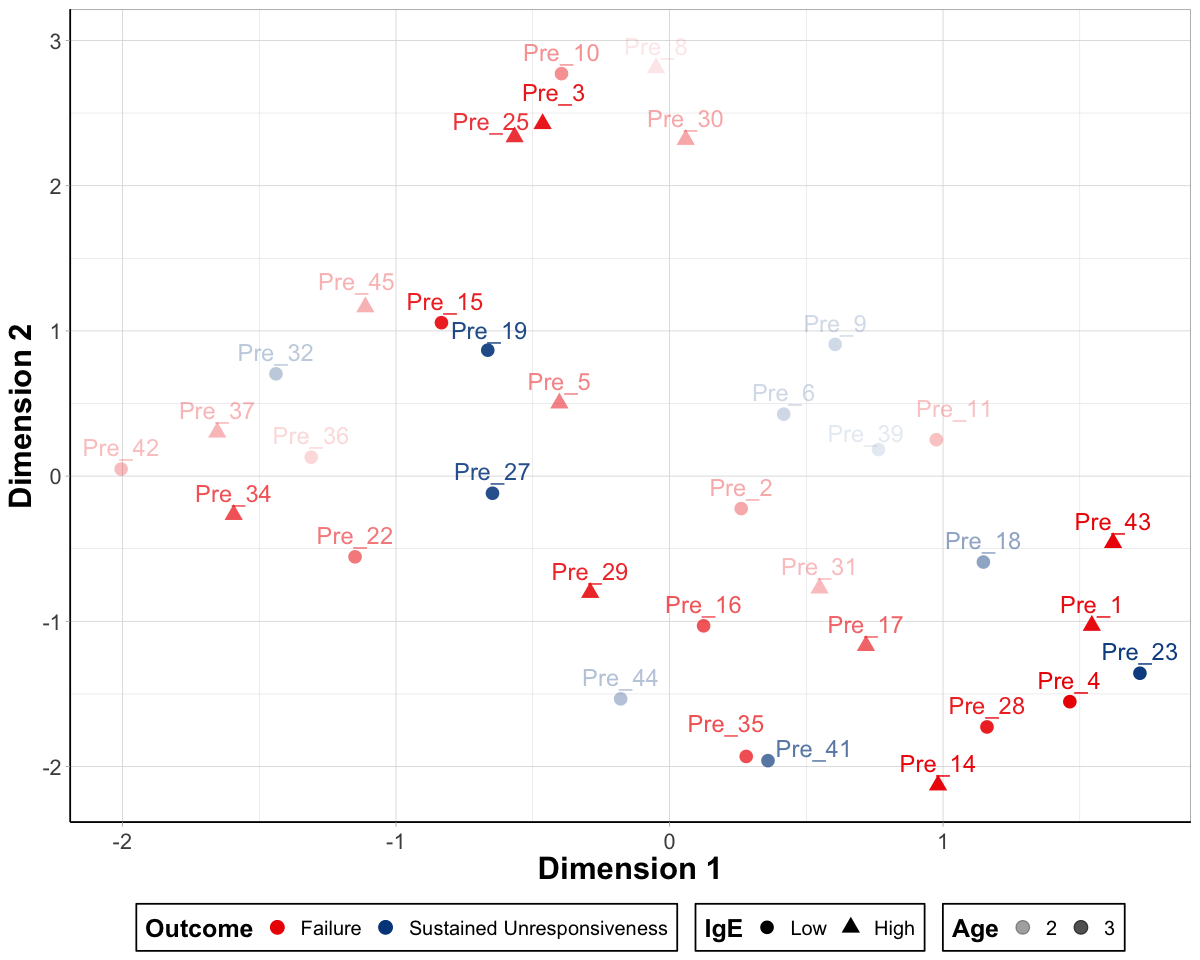

In [44]:
options(repr.plot.width=10, repr.plot.height=8) #changing size
lancet_palette = pal_lancet()(2)

ggplot(saliva_umap_outcome_df, aes(x = X, y = Y, color = Outcome, shape = IgE, alpha = Age)) + 
  geom_point(size = 3.5) + 
  geom_text_repel(data = saliva_umap_outcome_df, 
                  aes(x = X, y = Y, label = Sample_ID), 
                  segment.size = 0, size = 5, show.legend = FALSE, nudge_y = 0.15) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  labs(x = 'Dimension 1', y = 'Dimension 2') + #changing axis labels 

  scale_color_manual(values = rev(lancet_palette))

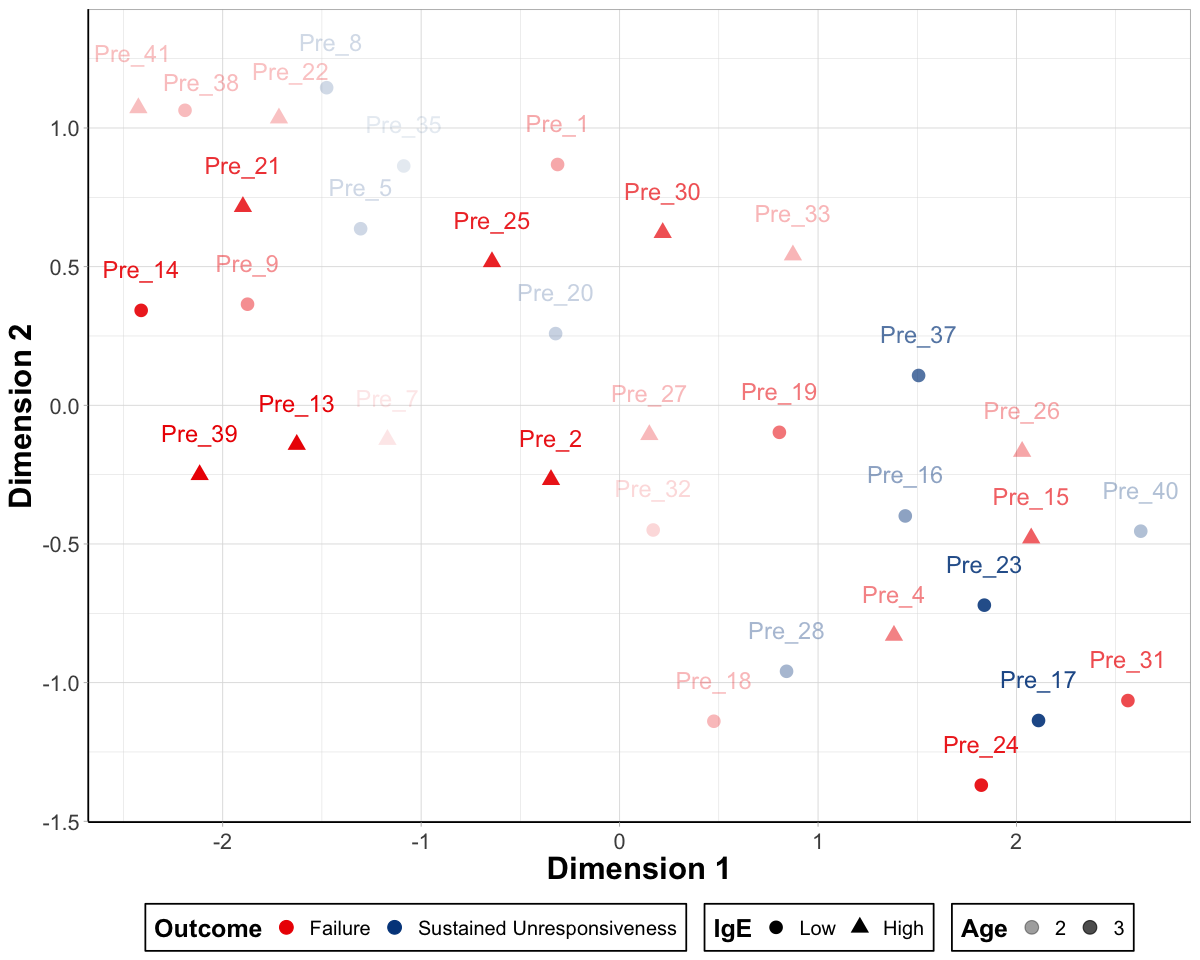

In [45]:
ggplot(stool_umap_outcome_df, aes(x = X, y = Y, color = Outcome, shape = IgE, alpha = Age)) + 
  geom_point(size = 3.5) + 
  geom_text_repel(data = stool_umap_outcome_df, 
                  aes(x = X, y = Y,  label = Sample_ID), 
                  segment.size = 0, size = 5, show.legend = FALSE, nudge_y = 0.15) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  labs(x = 'Dimension 1', y = 'Dimension 2') + #changing axis labels 

  scale_color_manual(values = rev(lancet_palette))

In [30]:
# setting seed for reproducibility
set.seed(12)

saliva_umap_ige = umap(v2_saliva_df[,c(9:ncol(v2_saliva_df))])
stool_umap_ige = umap(v2_stool_df[,c(10:ncol(v2_stool_df))])

saliva_umap_ige_df = data.frame(X = saliva_umap_ige$layout[,1],
                     Y = saliva_umap_ige$layout[,2],
                     IgE = v2_saliva_df$IgE_Binarized,
                     Age = v2_saliva_df$Age) %>%
    mutate(IgE = factor(IgE, levels = c('Low', 'High'))) %>%
    rownames_to_column('Sample_ID')

stool_umap_ige_df = data.frame(X = stool_umap_ige$layout[,1],
                     Y = stool_umap_ige$layout[,2],
                     IgE = v2_stool_df$IgE_Binarized,
                     Age = v2_stool_df$Age) %>%
    mutate(IgE = factor(IgE, levels = c('Low', 'High'))) %>%
    rownames_to_column('Sample_ID')

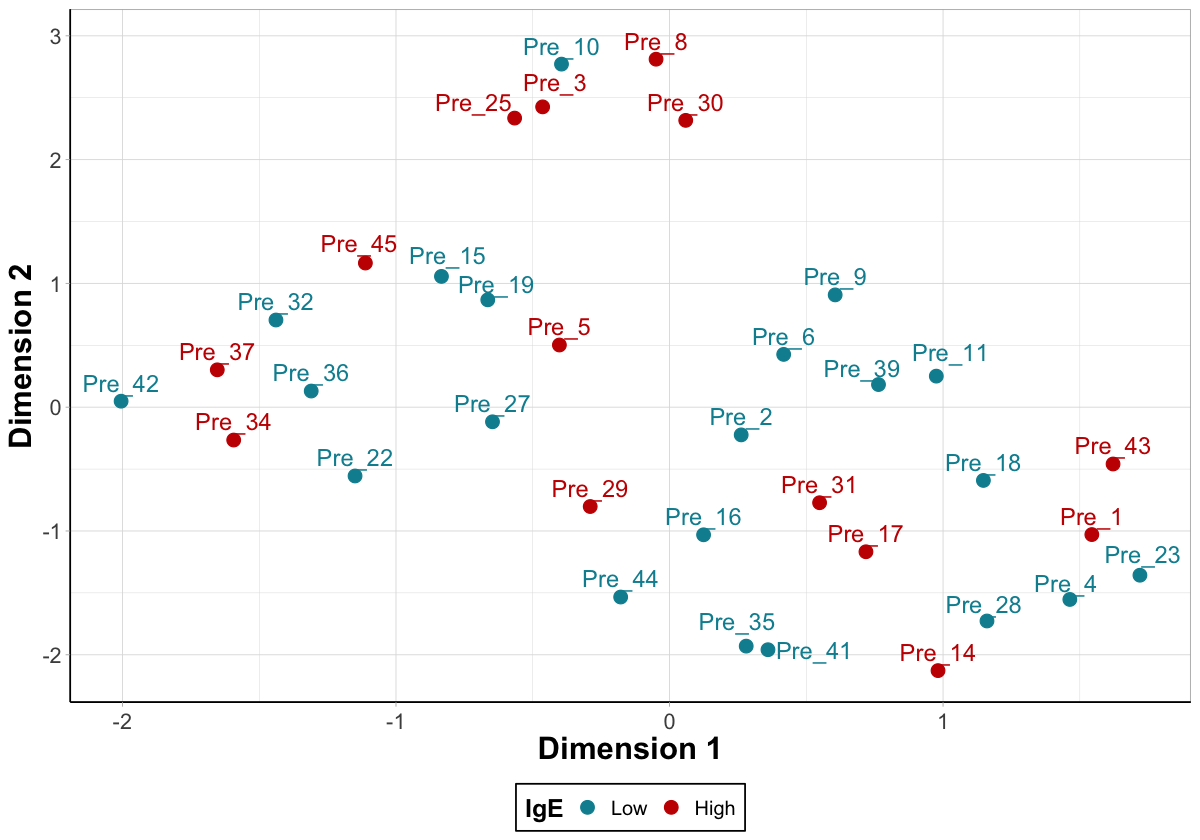

In [31]:
futurama_palette = pal_futurama()(3)

ggplot(saliva_umap_ige_df, aes(x = X, y = Y, color = IgE)) + 
  geom_point(size = 3.5) + 
  geom_text_repel(data = saliva_umap_ige_df, 
                  aes(x = X, y = Y, label = Sample_ID), 
                  segment.size = 0, size = 5, show.legend = FALSE, nudge_y = 0.15) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  labs(x = 'Dimension 1', y = 'Dimension 2') + #changing axis labels 

  scale_color_manual(values = futurama_palette[3:2])

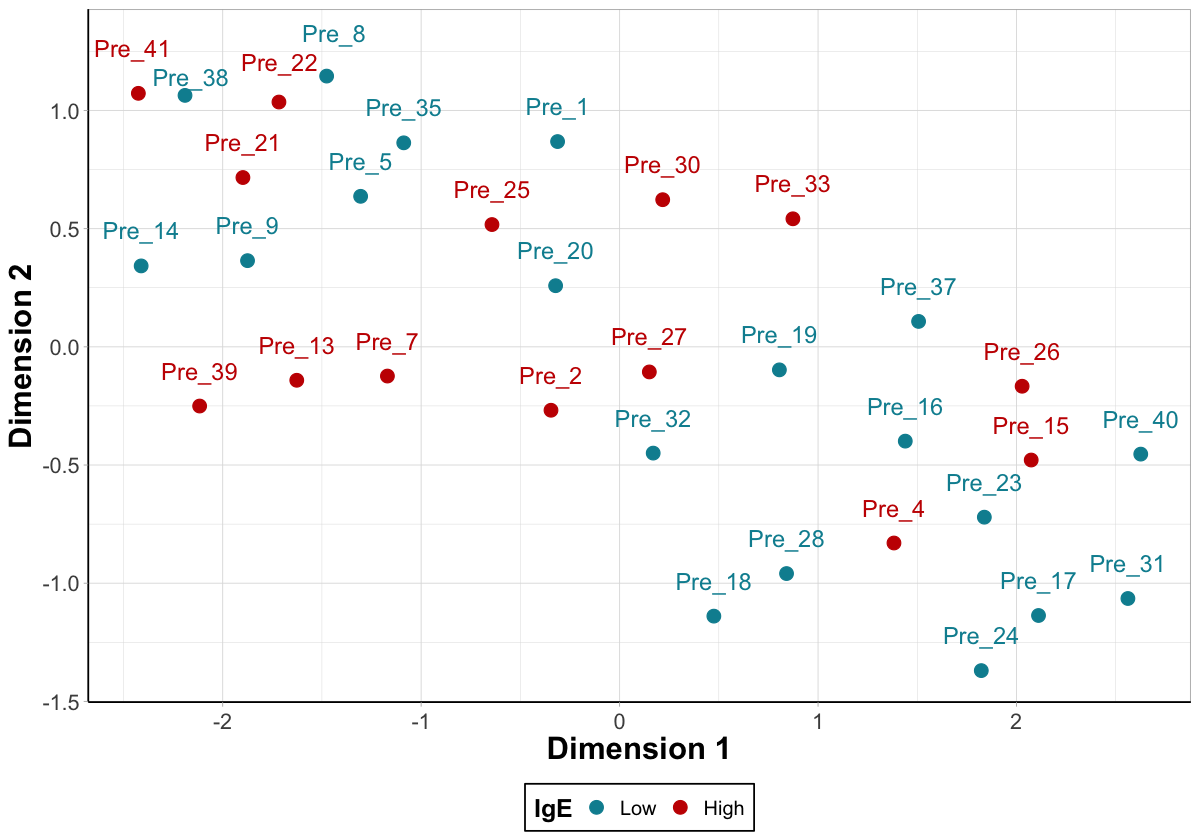

In [32]:
ggplot(stool_umap_ige_df, aes(x = X, y = Y, color = IgE)) + 
  geom_point(size = 3.5) + 
  geom_text_repel(data = stool_umap_ige_df, 
                  aes(x = X, y = Y, label = Sample_ID), 
                  segment.size = 0, size = 5, show.legend = FALSE, nudge_y = 0.15) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  labs(x = 'Dimension 1', y = 'Dimension 2') + #changing axis labels 

  scale_color_manual(values = futurama_palette[3:2])

In [33]:
set.seed(12)

saliva_umap_paired = umap(paired_saliva_df[,c(9:ncol(paired_saliva_df))])
stool_umap_paired = umap(paired_stool_df[,c(10:ncol(paired_stool_df))])

saliva_umap_paired_df = data.frame(X = saliva_umap_paired$layout[,1],
                     Y = saliva_umap_paired$layout[,2],
                     Time_Point = paired_saliva_df$Time_Point,
                     Outcome = paired_saliva_df$Outcome,
                     Age = paired_saliva_df$Age,
                     IgE = paired_saliva_df$IgE_Binarized) %>%
    mutate(IgE = factor(IgE, levels = c('Low', 'High')),
          Time_Point = factor(Time_Point, levels = c('Pre', 'Post'))) 

stool_umap_paired_df = data.frame(X = stool_umap_paired$layout[,1],
                     Y = stool_umap_paired$layout[,2],
                     Time_Point = paired_stool_df$Time_Point,
                     Outcome = paired_stool_df$Outcome,
                     Age = paired_stool_df$Age,
                     IgE = paired_stool_df$IgE_Binarized) %>%
    mutate(IgE = factor(IgE, levels = c('Low', 'High')),
          Time_Point = factor(Time_Point, levels = c('Pre', 'Post'))) 

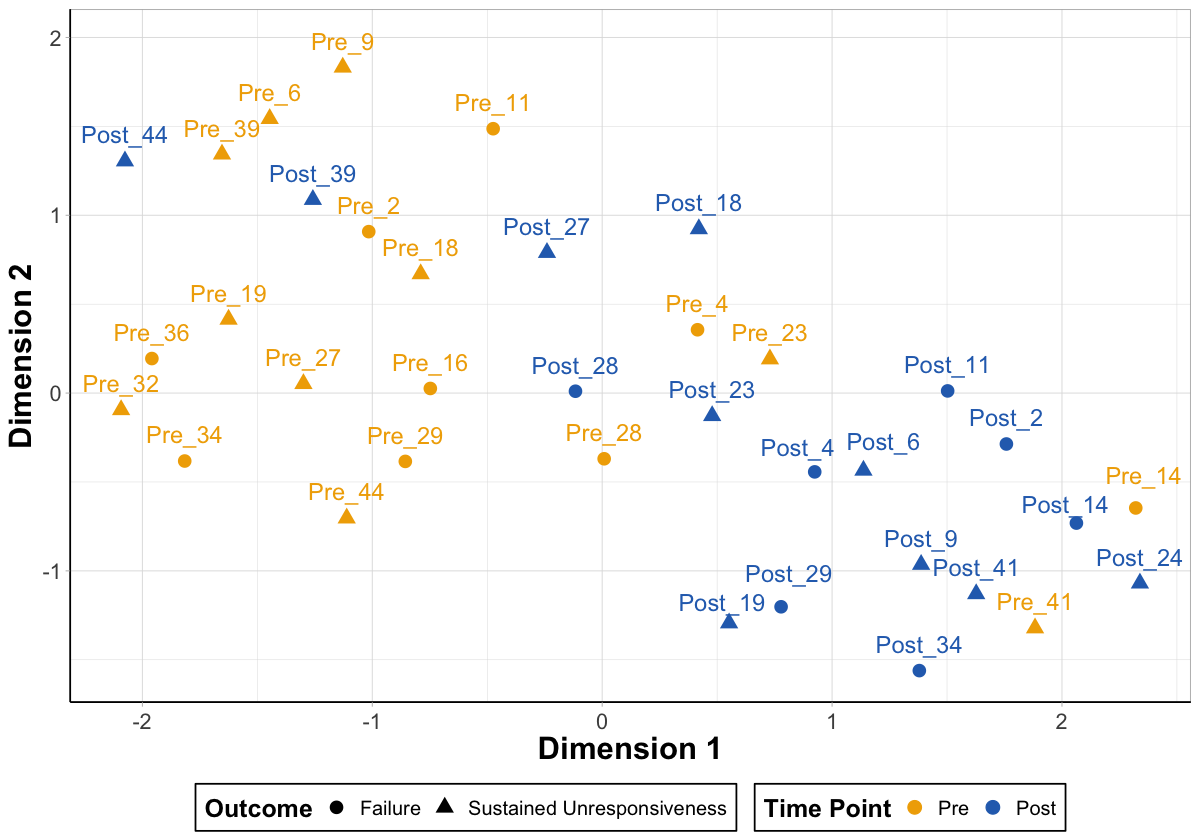

In [34]:
bmj_palette = pal_bmj()(2)

ggplot(saliva_umap_paired_df, aes(x = X, y = Y, color = Time_Point, shape = Outcome)) + 
  geom_point(size = 3.5) + 
  geom_text_repel(data = saliva_umap_paired_df, 
                  aes(x = X, y = Y, label = Sample_ID), 
                  segment.size = 0, size = 5, show.legend = FALSE, nudge_y = 0.15) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  labs(x = 'Dimension 1', y = 'Dimension 2') + #changing axis labels 

  scale_color_manual(name = 'Time Point', values = rev(bmj_palette))

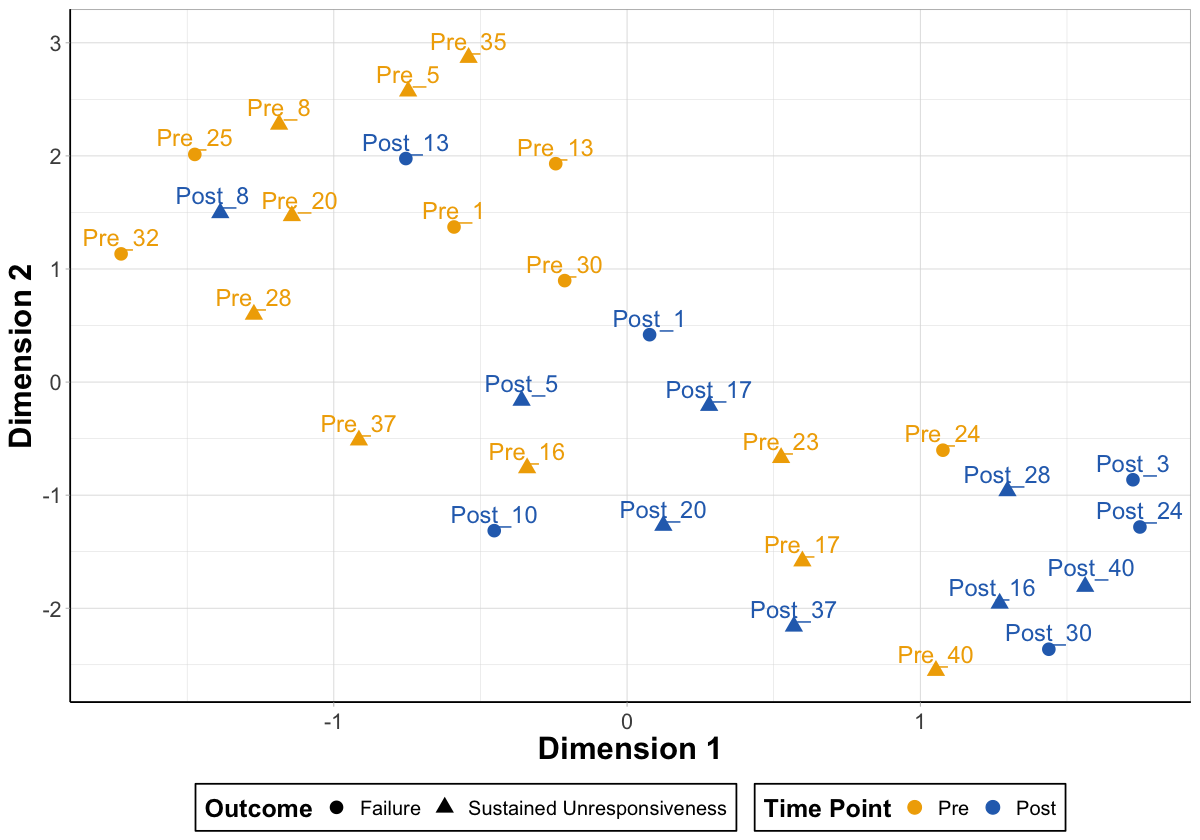

In [35]:
ggplot(stool_umap_paired_df, aes(x = X, y = Y, color = Time_Point, shape = Outcome)) + 
  geom_point(size = 3.5) + 
  geom_text_repel(data = stool_umap_paired_df, 
                  aes(x = X, y = Y,  label = Sample_ID), 
                  segment.size = 0, size = 5, show.legend = FALSE, nudge_y = 0.15) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  labs(x = 'Dimension 1', y = 'Dimension 2') + #changing axis labels 

  scale_color_manual(name = 'Time Point', values = rev(bmj_palette))

## Paired take 2

In [68]:
paired_saliva_df2 = saliva_df  %>%
    # removing those failed the IgE protein
    filter(IgE_Binarized != 'Fail')  %>%
    # ended up reassinging 'DS' to 'F' due to small sample size
    mutate(Outcome = ifelse(Outcome == 'DS', 'F', Outcome)) %>%
    mutate(across(c(10:ncol(saliva_df)), ~ log(.x + 2))) %>%
    # removing 13 participants that don't have pre and post samples
    filter(Subject_No %notin% c(1,12,13,16,17,20,24,26,31,32,36,37,43),
    # retaining those given treatment
          Treatment == 'A') %>%
    # cleaning variable names here
    mutate(Outcome = ifelse(Outcome == "F", "Failure",
                                  ifelse(Outcome == "SU", "Sustained Unresponsiveness", Outcome)))

paired_stool_df2 = stool_df  %>%
    filter(IgE_Binarized != 'Fail') %>%
    mutate(Outcome = ifelse(Outcome == 'DS', 'F', Outcome)) %>%
    mutate(across(c(11:ncol(stool_df)), ~ log(.x + 2))) %>%
    # removing 10 participants that don't have pre and post samples
    filter(Subject_No %notin% c(3,10,14,15,23,25,27,32,35,39),
          Treatment == 'A') %>%
    # cleaning variable names here
    mutate(Outcome = ifelse(Outcome == "F", "Failure",
                                  ifelse(Outcome == "SU", "Sustained Unresponsiveness", Outcome)))

head(paired_saliva_df2)

,Original_Sample_ID,Subject_No,Sample_ID,Time_Point,Treatment,Outcome,Age,IgE,IgE_Binarized,k__Bacteria.__.__.__.__.__.__,⋯,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.__.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Aggregatibacter.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Aggregatibacter.s__aphrophilus,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Haemophilus.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Haemophilus.s__parainfluenzae,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..__,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..s__bacterium_HMT_347,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..s__bacterium_HMT_352,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.3..s__bacterium_HMT_351,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.6..s__bacterium_HMT_870
,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,FS0236mo,2,Post_2,Post,A,Failure,1.873973,14.20,Low,4.1743873,⋯,6.5510803,0.6931472,3.8066625,4.605170,7.413970,0.6931472,0.6931472,6.0520892,4.9972123,4.828314
2,FS02baseline,2,Pre_2,Pre,A,Failure,1.873973,14.20,Low,0.6931472,⋯,0.6931472,0.6931472,3.8712010,5.921578,8.119994,0.6931472,0.6931472,0.6931472,0.6931472,4.736198
3,FS0536mo,4,Post_4,Post,A,Failure,3.991781,9.59,Low,2.0794415,⋯,0.6931472,2.9444390,0.6931472,4.948760,7.833204,0.6931472,0.6931472,6.2225763,3.7135721,4.634729
4,FS05baseline,4,Pre_4,Pre,A,Failure,3.991781,9.59,Low,3.2580965,⋯,0.6931472,0.6931472,0.6931472,4.718499,7.112327,3.7376696,1.7917595,6.0038871,3.6109179,5.129899
5,FS0736mo,6,Post_6,Post,A,Sustained Unresponsiveness,1.419178,1.32,Low,1.3862944,⋯,0.6931472,0.6931472,0.6931472,6.142037,7.407318,2.1972246,0.6931472,5.1298987,4.1431347,6.084499
6,FS07baseline,6,Pre_6,Pre,A,Sustained Unresponsiveness,1.419178,1.32,Low,2.1972246,⋯,0.6931472,0.6931472,0.6931472,7.748029,7.590852,0.6931472,2.8903718,0.6931472,1.9459101,3.401197


In [82]:
# getting FC
log_saliva_df = lag(paired_saliva_df2[,10:ncol(saliva_df)])/paired_saliva_df2[,10:ncol(saliva_df)]
log_saliva_df = log_saliva_df[seq_len(nrow(log_saliva_df)) %% 2 == 0, ]
log2FC_saliva_df = cbind(paired_saliva_df2[,c(2,6:9)] %>%
                               unique() %>% 
                               remove_rownames %>%
                               column_to_rownames('Subject_No'), log_saliva_df)

log_stool_df = lag(paired_stool_df2[,11:ncol(stool_df)])/paired_stool_df2[,11:ncol(stool_df)]
log_stool_df = log_stool_df[seq_len(nrow(log_stool_df)) %% 2 == 0, ]
log2FC_stool_df = cbind(paired_stool_df2[,c(3,7:10)] %>%
                               unique() %>% 
                               remove_rownames %>%
                               column_to_rownames('Subject_No'), log_stool_df)

head(log2FC_saliva_df)

,Outcome,Age,IgE,IgE_Binarized,k__Bacteria.__.__.__.__.__.__,k__Bacteria.p__Absconditabacteria_.SR1..c__Absconditabacteria_.SR1._.C.1..o__Absconditabacteria_.SR1._.O.1..f__Absconditabacteria_.SR1._.F.1..g__Absconditabacteria_.SR1._.G.1..s__bacterium_HMT_874,k__Bacteria.p__Absconditabacteria_.SR1..c__Absconditabacteria_.SR1._.C.1..o__Absconditabacteria_.SR1._.O.1..f__Absconditabacteria_.SR1._.F.1..g__Absconditabacteria_.SR1._.G.1..s__bacterium_HMT_875,k__Bacteria.p__Actinobacteria.c__Actinomycetia.o__Actinomycetales.f__Actinomycetaceae.g__Actinomyces.__,k__Bacteria.p__Actinobacteria.c__Actinomycetia.o__Actinomycetales.f__Actinomycetaceae.g__Actinomyces.s__graevenitzii,k__Bacteria.p__Actinobacteria.c__Actinomycetia.o__Actinomycetales.f__Actinomycetaceae.g__Schaalia.s__lingnae,⋯,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.__.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Aggregatibacter.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Aggregatibacter.s__aphrophilus,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Haemophilus.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Haemophilus.s__parainfluenzae,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..__,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..s__bacterium_HMT_347,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..s__bacterium_HMT_352,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.3..s__bacterium_HMT_351,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.6..s__bacterium_HMT_870
,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,Failure,1.873973,14.20,Low,6.0223678,1.140281,8.647458,1.0888268,1.2622362,1.3470711,⋯,9.451211,1.000000,0.9833286,0.7776930,0.9130512,1.000000,1.0000000,8.7313190,7.209453,1.0194492
4,Failure,3.991781,9.59,Low,0.6382382,1.000000,1.623249,0.7974088,1.1740045,0.1714416,⋯,1.000000,4.247928,1.0000000,1.0487996,1.1013559,0.185449,0.3868528,1.0364246,1.028429,0.9034738
6,Sustained Unresponsiveness,1.419178,1.32,Low,0.6309298,4.700440,1.000000,1.0305566,1.5563025,4.5235620,⋯,1.000000,1.000000,1.0000000,0.7927226,0.9758216,3.169925,0.2398125,7.4008794,2.129150,1.7889286
9,Sustained Unresponsiveness,1.389041,0.42,Low,1.1005724,1.000000,1.000000,1.4281986,8.0056245,6.0443941,⋯,1.000000,1.000000,1.0000000,0.5133670,0.9129980,2.584963,1.0000000,8.9158794,4.643856,2.7702106
11,Failure,1.567123,4.34,Low,1.4771213,3.807355,1.000000,1.5424305,2.0714662,1.0162105,⋯,1.000000,1.000000,1.0000000,2.2108715,1.0270003,1.000000,1.0000000,1.7658363,1.952672,1.5892510
14,Failure,3.912329,105.00,High,1.9534453,1.000000,1.000000,0.9052225,0.8867124,0.1433223,⋯,1.755875,1.000000,1.0000000,1.8356838,1.4479534,1.000000,1.0000000,0.8403361,1.244094,0.1707073


In [83]:
set.seed(12)

saliva_umap_paired = umap(log2FC_saliva_df[,c(5:ncol(log2FC_saliva_df))], n_neighbors = 10)
stool_umap_paired = umap(log2FC_stool_df[,c(5:ncol(log2FC_stool_df))], n_neighbors = 10)

saliva_umap_paired_df = data.frame(X = saliva_umap_paired$layout[,1],
                     Y = saliva_umap_paired$layout[,2],
                     Outcome = log2FC_saliva_df$Outcome,
                     Age = log2FC_saliva_df$Age,
                     IgE = log2FC_saliva_df$IgE_Binarized,
                     SubjectNo = rownames(log2FC_saliva_df)) %>%
    mutate(IgE = factor(IgE, levels = c('Low', 'High'))) 

stool_umap_paired_df = data.frame(X = stool_umap_paired$layout[,1],
                     Y = stool_umap_paired$layout[,2],
                     Outcome = log2FC_stool_df$Outcome,
                     Age = log2FC_stool_df$Age,
                     IgE = log2FC_stool_df$IgE_Binarized,
                     SubjectNo = rownames(log2FC_stool_df)) %>%
    mutate(IgE = factor(IgE, levels = c('Low', 'High'))) 

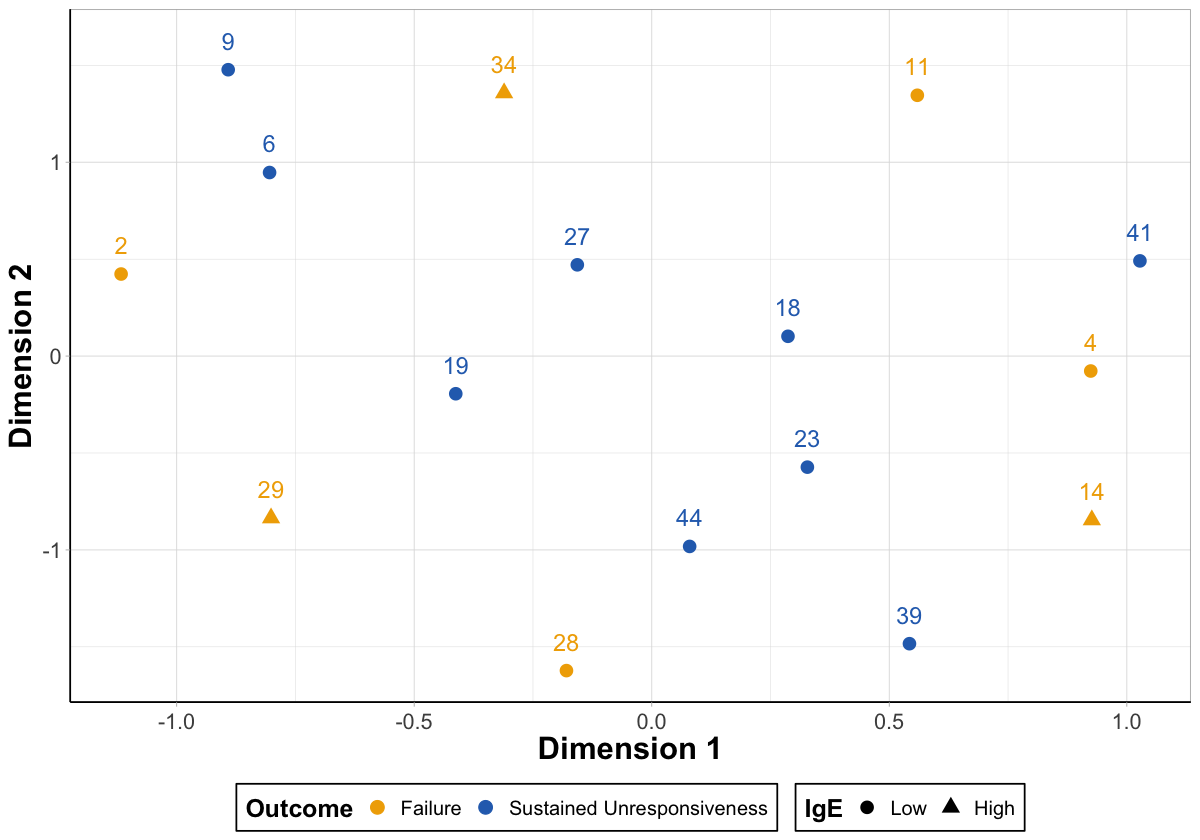

In [85]:
ggplot(saliva_umap_paired_df, aes(x = X, y = Y, color = Outcome, shape = IgE)) + 
  geom_point(size = 3.5) + 
  geom_text_repel(data = saliva_umap_paired_df, 
                  aes(x = X, y = Y, label = SubjectNo), 
                  segment.size = 0, size = 5, show.legend = FALSE, nudge_y = 0.15) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  labs(x = 'Dimension 1', y = 'Dimension 2') + #changing axis labels 

  scale_color_manual(values = rev(bmj_palette))

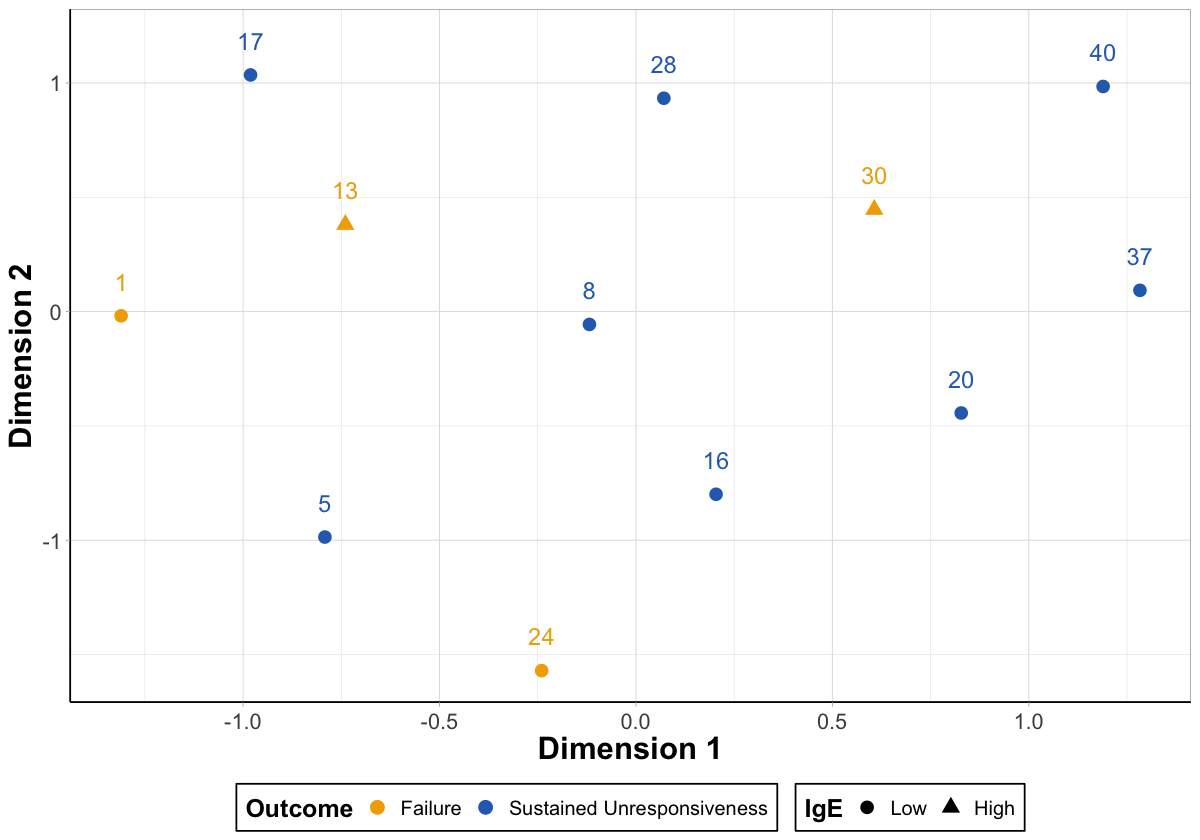

In [86]:
ggplot(stool_umap_paired_df, aes(x = X, y = Y, color = Outcome, shape = IgE)) + 
  geom_point(size = 3.5) + 
  geom_text_repel(data = stool_umap_paired_df, 
                  aes(x = X, y = Y, label = SubjectNo), 
                  segment.size = 0, size = 5, show.legend = FALSE, nudge_y = 0.15) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  labs(x = 'Dimension 1', y = 'Dimension 2') + #changing axis labels 

  scale_color_manual(values = rev(bmj_palette))